In [1]:
import openslide
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import valis
import cv2

import seaborn as sns

/well/rittscher/users/qdv200/conda/skylake/envs/valis_env/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/well/rittscher/users/qdv200/conda/skylake/envs/valis_env/lib/python3.10/site-packages/valis/affine_optimizer.py:311: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nba.jit()
/well/rittscher/users/qdv200/conda/skylake/envs/valis_env/lib/python3.10/site-packages/valis/affi

In [37]:
x_sc=100
y_sc=100

175.0
42.0


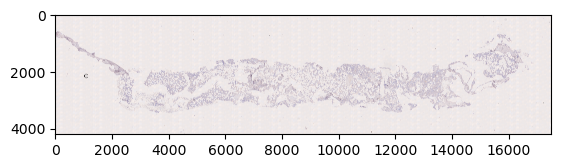

In [34]:
#get image mask

x_sc=100
y_sc=100

#make tiles
image = "b-ET-CALR-2021-02-19-11-12-00.ndpi"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/"

slide_path = os.path.join(filepath, image)

slide = open_slide(slide_path)

print(slide.level_dimensions[0][0]/512)
print(slide.level_dimensions[0][1]/512)

img = slide.get_thumbnail(((slide.level_dimensions[0][0]/512)*x_sc, (slide.level_dimensions[0][1]/512)*y_sc))
img = np.array(img)

plt.imshow(img)


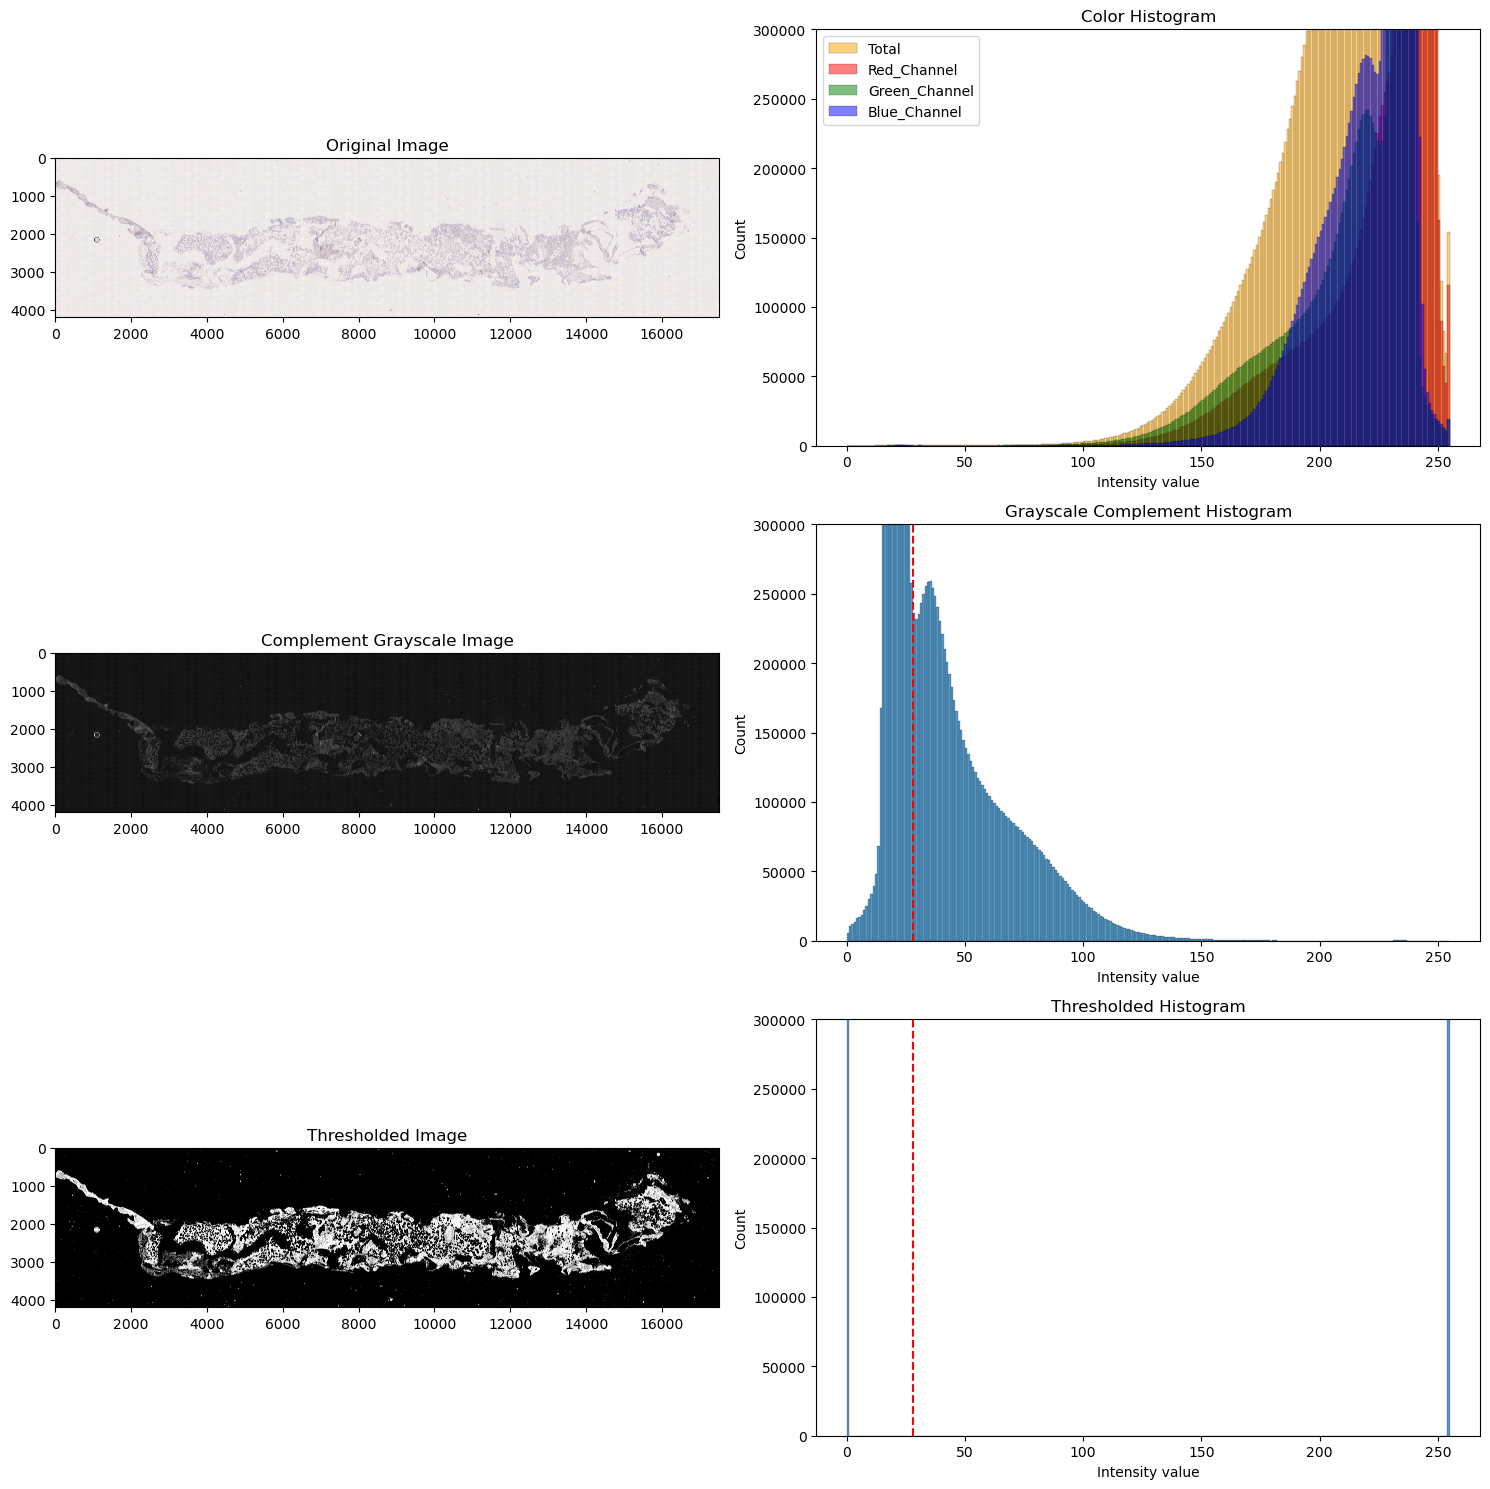

In [35]:
#https://www.kaggle.com/code/nghihuynh/wsi-preprocessing-tiling-tissue-segmentation
#apply otsu to get tissue mask

def thresholding(img, method='otsu'):
    # convert to grayscale complement image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_c = 255 - grayscale_img
    thres, thres_img = 0, img_c.copy()
    if method == 'otsu':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'triangle':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)
    return thres, thres_img, img_c

def histogram(img, thres_img, img_c, thres):
    """
    style: ['color', 'grayscale']
    """ 
    plt.figure(figsize=(15,15))
    
    plt.subplot(3,2,1)
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(3,2,2)
    sns.histplot(img.ravel(), bins=np.arange(0,256), color='orange', alpha=0.5)
    sns.histplot(img[:,:,0].ravel(), bins=np.arange(0,256), color='red', alpha=0.5)
    sns.histplot(img[:,:,1].ravel(), bins=np.arange(0,256), color='Green', alpha=0.5)
    sns.histplot(img[:,:,2].ravel(), bins=np.arange(0,256), color='Blue', alpha=0.5)
    plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Color Histogram')
    
    plt.subplot(3,2,3)
    plt.imshow(img_c, cmap='gist_gray')
    plt.title('Complement Grayscale Image')
    
    plt.subplot(3,2,4)
    sns.histplot(img_c.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Grayscale Complement Histogram')
    
    plt.subplot(3,2,5)
    plt.imshow(thres_img, cmap='gist_gray')
    plt.title('Thresholded Image')
    
    plt.subplot(3,2,6)
    sns.histplot(thres_img.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Thresholded Histogram')
    
    plt.tight_layout()
    plt.show()

thres, thres_img, img_c = thresholding(img, method='triangle')
histogram(img, thres_img, img_c, thres)

In [48]:
#get the tiles which are tissue

#split thres im into tiles

# sx, sy = slide.dimensions
# ix, iy = thres_img.shape

# ratiox = sx/512
# ratioy = sy/512

M = x_sc
N = y_sc

print(M, N)

#https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python

tile_dict = {}
for x in range(0,thres_img.shape[0],M):
    for y in range(0,thres_img.shape[1],N):
        tile = thres_img[x:x+M,y:y+N]
        if tile.mean() > thres:
            tile_dict[(y/y_sc, x/x_sc)] = tile
        else:
            pass

print(thres_img.shape[0]/M)
print(thres_img.shape[1]/N)
print(slide.dimensions[0]/512)
print(slide.dimensions[1]/512)

100 100
42.0
175.0
175.0
42.0


In [46]:
tile_dict[(20,100)].mean()

211.62450000000001

In [ ]:
#make tiles
image = "b-ET-CALR-2021-02-19-11-12-00.ndpi"

base = "/well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/"
slide = open_slide(os.path.join(filepath, image))

try:
    to_unicode = unicode
except NameError:
    to_unicode = str

#MAKE IHC IMAGES

tiles = DeepZoomGenerator(slide, tile_size=512, overlap=0, limit_bounds=False)
n = tiles.level_count
cols, rows = tiles.level_tiles[n-1]
for row in range(rows):
        for col in range(cols):

            image_name = os.path.splitext(image)[0]
            tile_dir = base
            if not os.path.exists(tile_dir):
                  os.makedirs(tile_dir) 
            
            tile_name = os.path.join(tile_dir, image_name + '_%d_%d' % (col, row))
            if not os.path.exists(os.path.join(tile_name + ".png")):
                print("Now saving tile with title: ", tile_name)
                temp_tile = tiles.get_tile(n-1, (col, row))
                temp_tile_RGB = temp_tile.convert('RGB')
                temp_tile_np = np.array(temp_tile_RGB)
                plt.imsave(tile_name + ".png", temp_tile_np)
            else: 
                 continue



In [ ]:
#convert these to he images
#apply the pretrained model

!python test.py --dataroot /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test --name ihc2he_pretrained --model test --no_dropout --num_test 7350